### Symbolic Encoding

Entropy를 계산하려면 메세지를 Encoding해야한다. 이번 절에서는 수익률에 기초하고 있는 문헌에 사용된 몇 가지 인코딩 체계를 알아본다. 비록 다음에 논의되지는 않지만, Fractional Differentiated features는 일부 memory를 가지고 있으므로 정보의 인코딩을 권장한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from FinancialMachineLearning.features.encoding import *
from FinancialMachineLearning.features.entropy import *

WINDOW_SIZE = 126

data = yf.download(
    'SPY', 
    start = '2000-01-01', 
    end = pd.to_datetime('today'),
    interval = '1d',
    progress = False
)

In [2]:
data['return'] = data['Adj Close'].pct_change()

#### Binomial Encoding

엔트로피 비율을 계산할 때는 연속 변수를 이산화해 각 값에 유한한 알파벳 코드를 부여해야 한다. 예를 들어서, 수익률 계열 $\{r_t\}$는 부호에 따라서 인코딩할 수 있다. 즉 $r_t > 0$일 때에는 1을 부여하고, $r_t < 0$에 대해서는 0을 부여하고, $r_t = 0$일 때에는 제거하는 경우를 생각할 수 있다. Binary Encoding은 가격 바로부터 수익률 계열이 추출될 때 $\vert r_t \vert$가 대략 상수이므로 자연스럽게 일어난다.

$\vert r_t \vert$가 광범위한 결과를 수용하면 Binary Encoding은 잠재적으로 유용한 정보를 버린다. 이는 특히 intraday bar로 작업할 경우 더욱 그렇다. 이는 tick data의 이질적 속성으로부터 초래된 이분산성에 영향을 받기 때문이다. 이 문제를 일부 해결하는 방법은 가격을 종속된 확률 프로세스로부터 추출하는 것이다. 이런 예로는 고정된 개수의 거래 혹은 거래대금에 대해 샘플링된 거래량 바나 거래대금 바가 있다. 시간에 따르지 않고 시장 주도로 작업하면 거래가 활발한 주기에서는 보다 빈번한 샘플링이 되고, 거래가 약할 경우에는 샘플링 빈도가 낮아지므로 $\vert \r_t \vert$를 규제화하게 돼 대규모 알파벳의 필요성을 줄인다.

In [3]:
data.loc[data['return'] > 0, 'bin'] = 1
data.loc[data['return'] < 0, 'bin'] = 0

#### Quantile Encoding

가격 바가 사용되지 않으면 2개 이상의 코드가 필요할 수 있다. 한가지 방법은 $\{r_t\}$가 속한 분위수에 따라서 각 $r_t$에 코드를 배분하는 것이다. 분위수 경계는 표본 내 주기를 사용해 결정한다. train sample 전반에 대해 각 문자별로 동일한 개수의 관측값이 배분되고, 샘플 외의 문자별로도 거의 동일한 개수의 관측값을 배분한다. 이 기법을 사용하면 어떤 코드는 다른 것에 비해 $r_t$ 범위의 더 큰 부분에 걸치게 된다. 이 균등 또는 균등에 가까운 분포의 코드는 평균적으로 엔트로피 수치를 증가시키는 경향이 있다.

In [4]:
quantile_dict = quantile_mapping(data['return'].dropna())

In [5]:
data['plug in quantile encoding'] = data['return'].rolling(window = WINDOW_SIZE).apply(
    lambda x : plug_in_entropy(
        encode_array(x, quantile_dict)
    )
)

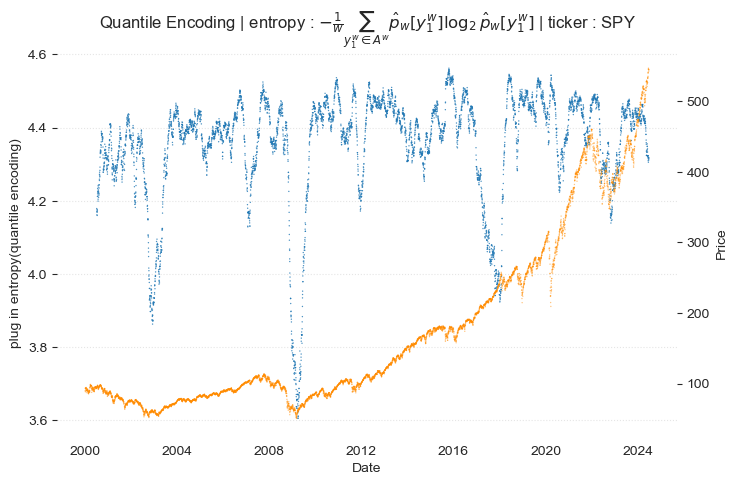

In [31]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.scatter(
    data['plug in quantile encoding'].index,
    data['plug in quantile encoding'],
    alpha = 0.8,
    s = 4,
    edgecolor = 'none',
    marker = '.'
)
ax1.set_xlabel('Date') 
ax1.set_ylabel('plug in entropy(quantile encoding)') 
ax1.grid(False)
ax1.yaxis.grid(True, ls=':', alpha=0.5)
for spine in ax1.spines.values():
    spine.set_visible(False)

ax2 = ax1.twinx() 
ax2.scatter(
    data['Adj Close'].index,
    data['Adj Close'],
    color = 'darkorange',
    marker = '.',
    alpha = 0.5,
    s = 4,
    edgecolor = 'none'
)
ax2.grid(False)
ax2.set_ylabel('Price') 
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.xticks(rotation = 45)
plt.title(r'Quantile Encoding | entropy : $-\frac{1}{w} \sum_{y_1^w \in A^w} \hat{p}_w[y_1^w] \log_2 \hat{p}_w [y_1^w]$ | ticker : SPY')
plt.show()

In [7]:
data['LZ quantile encoding'] = data['return'].rolling(window = WINDOW_SIZE).apply(
    lambda x : lempel_ziv_entropy(
        encode_array(x, quantile_dict)
    )
)

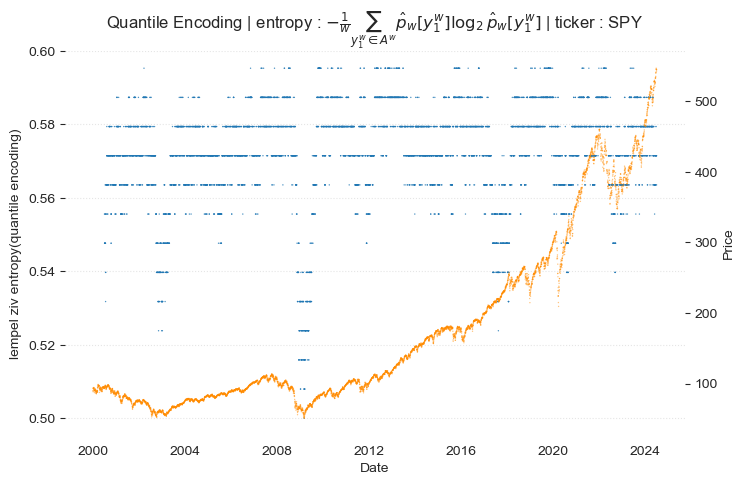

In [30]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.scatter(
    data['LZ quantile encoding'].index,
    data['LZ quantile encoding'],
    alpha = 0.8,
    s = 4,
    edgecolor = 'none',
    marker = '.'
)
ax1.set_xlabel('Date') 
ax1.set_ylabel('lempel ziv entropy(quantile encoding)') 
ax1.grid(False)
ax1.yaxis.grid(True, ls=':', alpha=0.5)
for spine in ax1.spines.values():
    spine.set_visible(False)

ax2 = ax1.twinx() 
ax2.scatter(
    data['Adj Close'].index,
    data['Adj Close'],
    color = 'darkorange',
    marker = '.',
    alpha = 0.5,
    s = 4,
    edgecolor = 'none'
)
ax2.grid(False)
ax2.set_ylabel('Price') 
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.xticks(rotation = 45)
plt.title(r'Quantile Encoding | entropy : $-\frac{1}{w} \sum_{y_1^w \in A^w} \hat{p}_w[y_1^w] \log_2 \hat{p}_w [y_1^w]$ | ticker : SPY')
plt.show()

In [9]:
data['Konto quantile encoding'] = data['return'].rolling(window = WINDOW_SIZE).apply(
    lambda x : konto_entropy(
        encode_array(x, quantile_dict)
    )
)

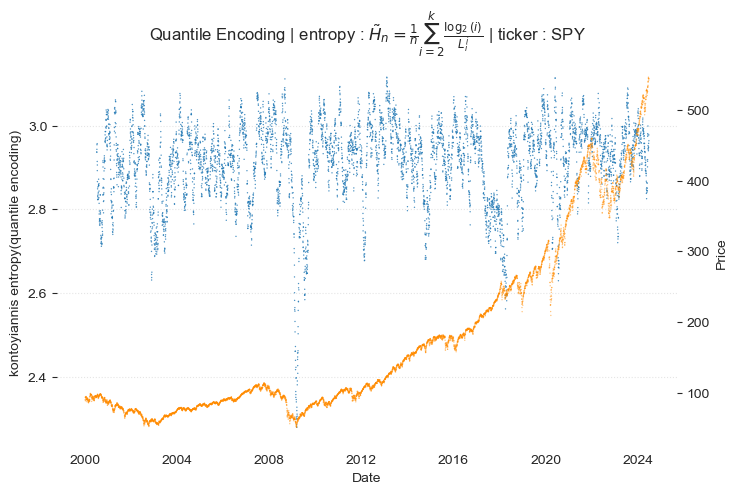

In [29]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.scatter(
    data['Konto quantile encoding'].index,
    data['Konto quantile encoding'],
    alpha = 0.8,
    s = 4,
    edgecolor = 'none',
    marker = '.'
)
ax1.set_xlabel('Date') 
ax1.set_ylabel('kontoyiannis entropy(quantile encoding)') 
ax1.grid(False)
ax1.yaxis.grid(True, ls=':', alpha=0.5)
for spine in ax1.spines.values():
    spine.set_visible(False)

ax2 = ax1.twinx() 
ax2.scatter(
    data['Adj Close'].index,
    data['Adj Close'],
    color = 'darkorange',
    marker = '.',
    alpha = 0.5,
    s = 4,
    edgecolor = 'none'
)
ax2.grid(False)
ax2.set_ylabel('Price') 
for spine in ax2.spines.values():
    spine.set_visible(False)

plt.xticks(rotation = 45)
plt.title(r'Quantile Encoding | entropy : $\tilde{H}_{n} = \frac{1}{n} \sum_{i=2}^k \frac{\log_2(i)}{L_i^i}$ | ticker : SPY')
plt.show()

#### Sigma Encoding

다른 방법으로는 코드 개수를 고정시키는 대신, 가격 흐름이 결정하도록 할 수 있다. 이산화 단계 $\sigma$를 고정시킨다고 가정해 보자. 그러면 $r_t \in \left[ \min \{r\}, \min\{r\} + \sigma\right)$에 0을 배분하고, $r_t \in \left[ \min \{r\} + \sigma, \min\{r\} + 2\sigma\right)$에 1을 배분하는 식으로 모든 관측값이 총 $\text{ceil}\left[ \frac{\max\{r\} - \min\{r\}}{\sigma}\right]$의 개수로 인코딩될 때까지 계속한다. 여기서 $\text{ceil[\cdot]}$은 올림 함수다. 각 코드는 분위수 인코딩과 달리 $r_t$범위의 동일한 부분을 차지한다. 코드는 균등 분포가 아니므로 엔트로피 수치는 분위수 인코딩에 비해 평균적으로 더 작은 경향이 있다. 그러나, 희귀한 코드의 출현(즉 market crash와 같은 이례적인 상황의 발생과 같은)은 엔트로피 수치에 spike를 초래할 것이다.

In [11]:
sigma_dict = sigma_mapping(data['return'].dropna().tolist())

In [15]:
data['plug in sigma encoding'] = data['return'].rolling(window = WINDOW_SIZE).apply(
    lambda x : plug_in_entropy(
        encode_array(x, sigma_dict)
    )
)

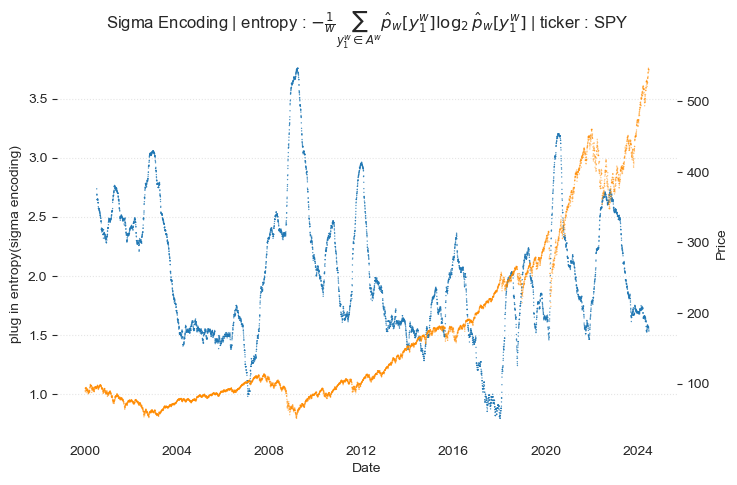

In [32]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.scatter(
    data['plug in sigma encoding'].index,
    data['plug in sigma encoding'],
    alpha = 0.8,
    s = 4,
    edgecolor = 'none',
    marker = '.'
)
ax1.set_xlabel('Date') 
ax1.set_ylabel('plug in entropy(sigma encoding)') 
ax1.grid(False)
ax1.yaxis.grid(True, ls=':', alpha=0.5)
for spine in ax1.spines.values():
    spine.set_visible(False)

ax2 = ax1.twinx() 
ax2.scatter(
    data['Adj Close'].index,
    data['Adj Close'],
    color = 'darkorange',
    marker = '.',
    alpha = 0.5,
    s = 4,
    edgecolor = 'none'
)
ax2.grid(False)
ax2.set_ylabel('Price') 
for spine in ax2.spines.values():
    spine.set_visible(False) 

plt.xticks(rotation = 45)
plt.title(r'Sigma Encoding | entropy : $-\frac{1}{w} \sum_{y_1^w \in A^w} \hat{p}_w[y_1^w] \log_2 \hat{p}_w [y_1^w]$ | ticker : SPY')
plt.show()

In [18]:
data['LZ sigma encoding'] = data['return'].rolling(window = WINDOW_SIZE).apply(
    lambda x : lempel_ziv_entropy(
        encode_array(x, sigma_dict)
    )
)

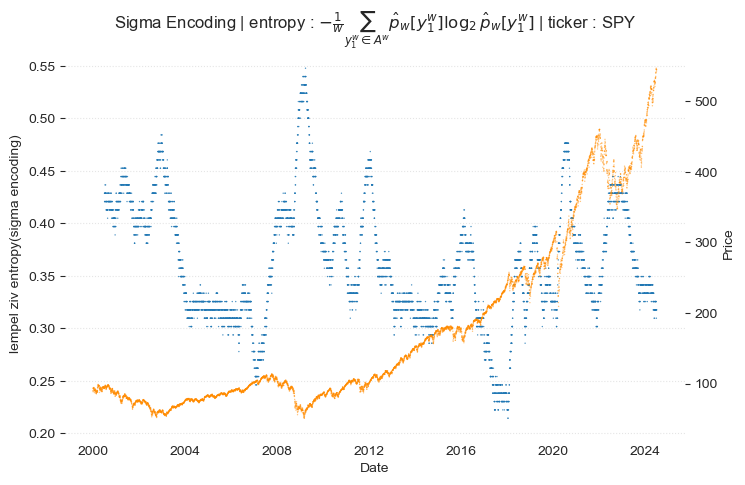

In [33]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.scatter(
    data['LZ sigma encoding'].index,
    data['LZ sigma encoding'],
    alpha = 0.8,
    s = 4,
    edgecolor = 'none',
    marker = '.'
)
ax1.set_xlabel('Date') 
ax1.set_ylabel('lempel ziv entropy(sigma encoding)') 
ax1.grid(False)
ax1.yaxis.grid(True, ls=':', alpha=0.5)
for spine in ax1.spines.values():
    spine.set_visible(False)

ax2 = ax1.twinx() 
ax2.scatter(
    data['Adj Close'].index,
    data['Adj Close'],
    color = 'darkorange',
    marker = '.',
    alpha = 0.5,
    s = 4,
    edgecolor = 'none'
)
ax2.grid(False)
ax2.set_ylabel('Price') 
for spine in ax2.spines.values():
    spine.set_visible(False) 

plt.xticks(rotation = 45)
plt.title(r'Sigma Encoding | entropy : $-\frac{1}{w} \sum_{y_1^w \in A^w} \hat{p}_w[y_1^w] \log_2 \hat{p}_w [y_1^w]$ | ticker : SPY')
plt.show()

In [20]:
data['Konto sigma encoding'] = data['return'].rolling(window = WINDOW_SIZE).apply(
    lambda x : konto_entropy(
        encode_array(x, sigma_dict)
    )
)

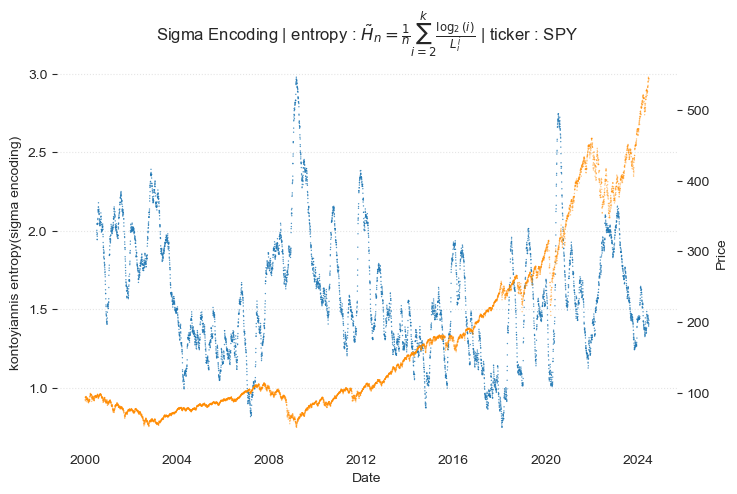

In [34]:
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.scatter(
    data['Konto sigma encoding'].index,
    data['Konto sigma encoding'],
    alpha = 0.8,
    s = 4,
    edgecolor = 'none',
    marker = '.'
)
ax1.set_xlabel('Date') 
ax1.set_ylabel('kontoyiannis entropy(sigma encoding)') 
ax1.grid(False)
ax1.yaxis.grid(True, ls=':', alpha=0.5)
for spine in ax1.spines.values():
    spine.set_visible(False)

ax2 = ax1.twinx() 
ax2.scatter(
    data['Adj Close'].index,
    data['Adj Close'],
    color = 'darkorange',
    marker = '.',
    alpha = 0.5,
    s = 4,
    edgecolor = 'none'
)
ax2.grid(False)
ax2.set_ylabel('Price') 
for spine in ax2.spines.values():
    spine.set_visible(False) 

plt.xticks(rotation = 45)
plt.title(r'Sigma Encoding | entropy : $\tilde{H}_{n} = \frac{1}{n} \sum_{i=2}^k \frac{\log_2(i)}{L_i^i}$ | ticker : SPY')
plt.show()